In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from math import ceil, log, exp
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors


tf.keras.utils.set_random_seed(seed=100)

## AutoEncoder 

In [51]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, x_train):
        super().__init__()
        self.encoder = self.encoder_model()
        self.decoder = self.decoder_model()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.train_data = x_train
        

    def encoder_model(self):
        encoder_inputs = keras.Input(shape=(6,)) # the shape is the number of dimensions and the length of data that will be put in. 
        # i.e. 6dims and 1 data points
        
        

        encoded = layers.Dense(5, activation='tanh')(encoder_inputs)
        encoded = layers.Dense(4, activation='tanh')(encoded)
        latent_space = layers.Dense(3, activation='tanh')(encoded) # this is the latent space (the output of the encoder)
        
        encoder = keras.Model(encoder_inputs, latent_space) # this defines the model in the keras computational graph
        encoder.compile(optimizer='Adam', loss='mse') # the compile step of the keras model
        encoder.summary()
        return encoder # returns the compiled model
    
    def decoder_model(self):
        decoder_inputs = keras.Input(shape=(3,)) # these are the inputs of the decoder (3dims (the latent space), 1 number of data points)
        decoded = layers.Dense(4, activation='tanh')(decoder_inputs)
        decoded = layers.Dense(5, activation='tanh')(decoded)     
        output_space = layers.Dense(6, activation='sigmoid')(decoded) # the output (decoded latent space, should be the inputs)
        
        decoder = keras.Model(decoder_inputs, output_space) # defining the decoder as a Model
        decoder.compile(optimizer='Adam', loss='mse') # compiling the model
        decoder.summary()
        return decoder # returning the compiled model
    
    
    
    def train_step(self, data): # as we have two parts of the model, we have to define how the model should be trained to access the latent space
        with tf.GradientTape() as tape:
            latent_output = self.encoder(data)
            reconstructed_data = self.decoder(latent_output)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mean_squared_logarithmic_error(data, reconstructed_data)))
            total_loss = reconstruction_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {'total_loss': self.total_loss_tracker.result(),
                'reconstruction_loss': self.reconstruction_loss_tracker.result()}

## Preprocessing Functions

In [52]:
class preprocessing:

    def map_unique_values(self, arr): #function to enforce even spacing in categorical data
        unique_values = list(set(arr))
        unique_values.sort() 
        value_to_number_mapping = {value: i + 1 for i, value in enumerate(unique_values)}
        mapped_array = np.array([value_to_number_mapping[value] for value in arr])
        return mapped_array
    
    def map_unique_values_to_columns(self, np_array):
        mapped_columns = []
        for col_idx in range(np_array.shape[1]):
            mapped_column = self.map_unique_values(np_array[:, col_idx])
            mapped_columns.append(mapped_column)
        return np.array(mapped_columns).T

    

    def order_by_frequency_array(self, data): #function used to value each data point based on freq
        value_counts = {}
        for value in data:
            if value in value_counts:
                value_counts[value] += 1
            else:
                value_counts[value] = 1
                
        sorted_values = sorted(value_counts.keys(), key=lambda x: value_counts[x], reverse=False)
        rank_mapping = {value: rank for rank, value in enumerate(sorted_values, start=1)}
        ranked_data = [rank_mapping[value] for value in data]
    
        return ranked_data


    def order_by_frequency(self, array): #function used to carry out valueing over each column
        output = []
        for column in array.T:
            ranked_data = self.order_by_frequency_array(column)
            output.append(ranked_data)
        output_array = np.column_stack(output)
    
        return output_array

    
    
    def min_max(array):
        min_val = np.min(array, axis=0)
        max_val = np.max(array, axis=0)
        normalized_array = (array - min_val) / (max_val - min_val)
        return normalized_array


    def min_max_odd_columns(array):
        normalized_array = np.empty_like(array)
        for i in range(array.shape[1]):
            if i % 2 != 0:
                normalized_array[:, i] = array[:, i]
            else: 
                min_val = np.min(array[:, i])
                max_val = np.max(array[:, i])
                normalized_array[:, i] = (array[:, i] - min_val) / (max_val - min_val)
        return normalized_array







## K-means Clustering

In [53]:
class clustering:

    def assign_clusters_find_distances(self, new_data, centroids):
            # calculate distances to centroids
            distances = np.linalg.norm(new_data[:, np.newaxis] - centroids, axis=2)
            
            # Assign each point to the closest centroid
            cluster_assignment = np.argmin(distances, axis=1)
            
            # Get distances to the closest centroid
            min_distances = np.min(distances, axis=1)
            
            return cluster_assignment, min_distances


    def kmean_clustering_with_distances(self, data, num_clusters):
        num_columns = data.shape[1]
        centroids_list = []
        assignment_distances_list = []
        
        # Iterate over each column
        for i in range(num_columns):
            # remove i-th column from the data
            data_subset = np.delete(data, i, axis=1)
            
            #K-means clustering
            kmeans = kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(data_subset)
            
            # record cluster centroids
            centroids = kmeans.cluster_centers_
            centroids_list.append(centroids)
            
            # get clusters and distances
            cluster_assignment, distances = self.assign_clusters_find_distances(data_subset, centroids)
            assignment_distances_list.append(cluster_assignment)
            assignment_distances_list.append(distances)
        
        # stack centroids into a single array
        stacked_centroids = np.stack(centroids_list, axis=1)
    
        # stack assignments and distances into a single array
        stacked_assignment_distances = np.column_stack(assignment_distances_list)
        
        return stacked_centroids, stacked_assignment_distances




    

    def kmeans_clustering_with_distances_new_data(self, stacked_centroids, data): 
            num_columns = stacked_centroids.shape[1]
            assignment_distances_list = []
            
            # Iterate over each column
            for i in range(num_columns):
                # Get the centroids for the current iteration
                centroids = stacked_centroids[:, i, :]
                
                # Remove the i-th column from the data
                data_subset = np.delete(data, i, axis=1)
                
                # Assign clusters and distances using the provided centroids
                cluster_assignment, distances = self.assign_clusters_find_distances(data_subset, centroids)
                assignment_distances_list.append(cluster_assignment)
                assignment_distances_list.append(distances)
            
            # Stack assignments and distances into a single array
            assignment_distances = np.column_stack(assignment_distances_list)
            
            return assignment_distances





## Data Analysis Functions

In [54]:
class data_analysis:

    def calculate_gradient(self, x, y):
        if len(x) != len(y):
            raise ValueError("Arrays must be of the same length")
        
        # Perform linear regression to find the slope (gradient)
        m, _ = np.polyfit(x, y, 1)
        
        return m

    def calculate_average_grad(self, data_set1, data_set2):
        gradients = []
        for i in range(data_set1.shape[1]):
            gradient = self.calculate_gradient(data_set1[:, i], data_set2[:, i])
            gradients.append(gradient)
        
        gradients = np.array(gradients)
        average_gradient = np.mean(gradients)
        
        return gradients, average_gradient


    def calculate_r_square(self, array1, array2):
            if array1.shape[1] != array2.shape[1]:
                raise ValueError("Arrays must have the same number of columns")
            
            r_squared_values = []
            for i in range(array1.shape[1]):
                correlation_matrix = np.corrcoef(array1[:, i], array2[:, i])
                correlation_coefficient = correlation_matrix[0, 1]
                r_squared = correlation_coefficient ** 2
                r_squared_values.append(r_squared)
        
            r_squared_values = np.array(r_squared_values)
            average_r_squared = np.mean(r_squared_values)
            
            return r_squared_values, average_r_squared
    
    def plot_hexbin_log_frequency(x, y, xlabel="", ylabel="", title="", gridsize=100, cmap='viridis', colorbar=True):
        """
        Function to create a hexbin plot with log-scaled frequency using Matplotlib.
        """
        plt.figure(figsize=(8, 6))
        
        # Calculate the hexbin frequencies
        hb = plt.hexbin(x, y, gridsize=gridsize, cmap=cmap)
        counts = hb.get_array()
        nonzero_counts = counts[counts != 0]
        
        # Set the norm to LogNorm with vmin=0
        norm = mcolors.LogNorm(vmin=1, vmax=nonzero_counts.max())
        hb = plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, norm=norm)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        
        if colorbar:
            plt.colorbar(hb, label='log(count)')
        
        plt.show()

## Preprocessing 

In [55]:
x_data_raw = np.loadtxt('train4 .csv',delimiter = ',') #import training data as numpy array

In [56]:
#seperate categorical and continuous
categorical_data = np.delete(x_data_raw, 5, axis=1)
x6 = x_data_raw[:, 5]

In [57]:
#create instances for classes
preprocessor = preprocessing()
Cluster = clustering()
Analyse = data_analysis()

In [58]:
#Preprocess Categorical Data

#apply even spacing

mapped = preprocessor.map_unique_values_to_columns(categorical_data)

#order

ordered = preprocessor.order_by_frequency(mapped)


#normalise 
ordered_min_max = preprocessing.min_max(ordered)

print(ordered_min_max)





[[0.72889694 1.         0.98461538 0.98848624 0.97415385]
 [0.01786639 1.         1.         0.883091   0.88      ]
 [0.17115484 1.         0.96923077 0.99785962 0.99938462]
 ...
 [0.88114966 1.         0.93846154 0.75798952 0.79630769]
 [0.17400311 1.         0.93846154 0.87881024 0.99938462]
 [0.42180218 1.         0.96923077 0.9988191  0.99815385]]


In [59]:
#Preprocess Continuous Data

log_x6 = np.log10(x6)
x6_logged_normalized = preprocessing.min_max(log_x6)


In [60]:
Input_data = np.column_stack((ordered_min_max, x6_logged_normalized))

In [61]:
df = pd.DataFrame(clustered, columns=['1', '2', '3','4','5','6','7','8','9','10'])
df.to_csv('Clustered input') 

In [62]:
x_train = Input_data
#x_test = Input_data[ceil(0.8*len(Input_data)):] change this to validation

## Train AutoEncoder

In [63]:
#Train AutoEncoder #after changing all test stuff, check that auto encoder still runs without test bit

AutoEncoder = AutoEncoder(x_train)
AutoEncoder.compile(optimizer=keras.optimizers.Adam())
AutoEncoder.fit(x_train, epochs= 2000 , batch_size=200)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_16 (Dense)            (None, 5)                 35        
                                                                 
 dense_17 (Dense)            (None, 4)                 24        
                                                                 
 dense_18 (Dense)            (None, 3)                 15        
                                                                 
Total params: 74 (296.00 Byte)
Trainable params: 74 (296.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input

## Analyse Training 

In [64]:
#Run with Trianing Data

latent_space_representation = AutoEncoder.encoder.predict(Input_data)

Output_data = AutoEncoder.decoder.predict(latent_space_representation)

6250/6250 [==============================] - 5s 795us/step


In [82]:
#Find Reconstruction Loss
Reconstruction_loss = np.mean(np.square(x_train - Output_data), axis = 1)
Threshold = np.percentile(Reconstruction_loss, 99.0)
print(Threshold)


0.025735347770744064


In [83]:
#Find Gradients
all_gradients, average_gradient = Analyse.calculate_average_grad(Input_data, Output_data)
print(average_gradient)


0.8333698438713845


In [84]:
#Find r^2 values
all_r_squared, average_r_squared = Analyse.calculate_r_square(Input_data, Output_data)
print(average_r_squared)

0.8377488843728934


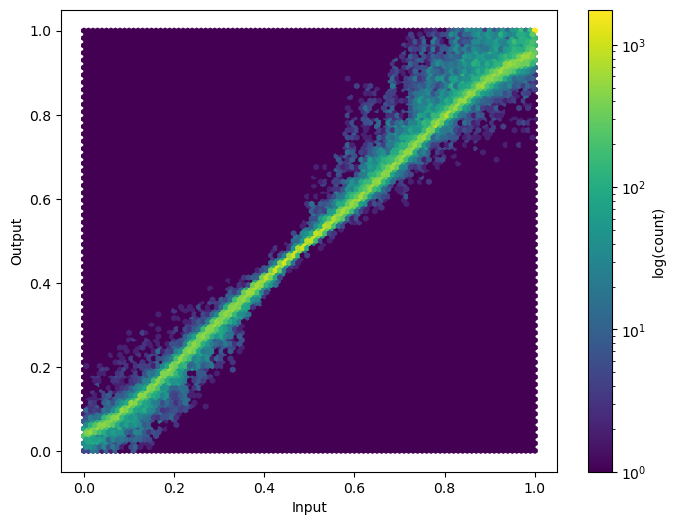

In [85]:
#Plot input vs output
#run through this to check it works with reset kernal!
data_analysis.plot_hexbin_log_frequency(Input_data[:,0], Output_data[:, 0] , xlabel='Input', ylabel='Output', title='') #change index to access different variable plots


# Test Trained Model

In [86]:
#import test data as numpy array 
Testing_data = np.loadtxt('testing_data2.csv',delimiter = ',')

## Preprocess Test data

In [87]:
#seperate categorical and continuous

categorical_data_test = np.delete(Testing_data, 5, axis=1)
x6_test = Testing_data[:, 5]

In [88]:
#Preprocess Categorical Data

#apply even spacing
mapped_test = preprocessor.map_unique_values_to_columns(categorical_data_test)


#order

ordered_test = preprocessor.order_by_frequency(mapped_test)

#normalise 
ordered_min_max_test = preprocessing.min_max(ordered_test)

In [89]:
#Preprocess continuous data

log_x6_test = np.log10(x6_test)
x6_logged_normalized_test = preprocessing.min_max(log_x6_test)



In [90]:
Input_data_test = np.column_stack((ordered_min_max_test, x6_logged_normalized_test))

## AutoEncoder on Test Data

In [91]:
latent_space_representation_test = AutoEncoder.encoder.predict(Input_data_test)

Output_data_test = AutoEncoder.decoder.predict(latent_space_representation_test)

1563/1563 [==============================] - 1s 731us/step


## Find Anomalies using Training Data Threshold

In [92]:
Reconstruction_loss = np.mean(np.square(Input_data_test - Output_data_test), axis = 1)

In [93]:
anomaly_truth = Reconstruction_loss > Threshold

anomaly_indices = np.where(anomaly_truth)[0]

anomalies = Input_data_test[anomaly_truth]

print("Anomalies:")
print(anomalies)

print("Indices of anomalies in Test_data:")
print(anomaly_indices)

print("Number of anomalies:", len(anomalies))

Anomalies:
[[0.59865355 0.44       0.6        0.43977259 0.62717481 0.66665395]
 [0.89383739 0.48       0.92307692 0.80267677 0.57497929 0.75760498]
 [0.27809425 0.56       0.72307692 0.63863556 0.73570837 0.79640081]
 ...
 [0.19808389 1.         0.36923077 0.43704844 0.27340514 0.90839573]
 [0.31097877 1.         0.63076923 0.43728533 0.9991715  0.73199517]
 [0.627913   0.56       0.78461538 0.74772    0.73570837 0.65869491]]
Indices of anomalies in Test_data:
[   33    80   111   155   190   231   252   292   348   435   556   722
   729   953  1043  1110  1186  1213  1241  1265  1269  1318  1334  1433
  1457  1517  1605  1629  1662  1735  1739  1813  1819  1907  1913  1993
  2045  2276  2283  2517  2621  2640  2712  2915  2923  2924  2937  3111
  3192  3297  3319  3328  3438  3466  3600  3640  3644  3652  3727  3786
  3792  3816  4020  4281  4290  4336  4359  4409  4483  4550  4641  4779
  4830  4887  5077  5105  5217  5258  5284  5353  5372  5622  5668  5790
  5873  5921  6033  606

## Test Data Analysis

In [94]:
Test_grad, Test_grad_average = Analyse.calculate_average_grad(Input_data_test, Output_data_test)
print(Test_grad_average)

0.8247409172437948


In [95]:
Test_R2, Test_R2_average = Analyse.calculate_r_square(Input_data_test, Output_data_test)
print(Test_R2_average)

0.8321407341933406


## Compare to George IDs

In [98]:
df = pd.read_csv('George_Anomalies.csv')
George_IDs = df['id']
array_of_values = np.array(George_IDs, dtype=int)

In [99]:
# Calculate the intersection of the two arrays
intersection = np.intersect1d(George_IDs, anomaly_indices)

# Get the number of values shared
shared_count = len(intersection)

print("Number of shared values:", shared_count)

Number of shared values: 70
